# Sistema de recomendacion de Anime

### Integrantes : 
-  Verónica Martinez
- Alejandra Aravena
- Hugo Zuñiga
- Cesar Flores

In [ ]:
#importar librerias
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler
from numpy import random

In [ ]:
# Cargamos la base de datos y realizamos algunas exploraciones

In [3]:
df_anime = pd.read_csv("Anime.csv", sep=';', decimal=',')
df_ratings = pd.read_csv("rating.csv")

In [4]:
df_anime.shape
#veamos numeros de filas y columnas 

(12294, 7)

In [5]:
df_ratings.shape
#veamos numeros de filas y columnas 

(7813737, 3)

In [6]:
df_ratings.info()
# informacion de las variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
user_id     int64
anime_id    int64
rating      int64
dtypes: int64(3)
memory usage: 178.8 MB


In [7]:
df_ratings.head()

user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

In [8]:
#Segun info otorgada el -1 corresponde a anime que no tiene valoracion por parte del usuario

In [9]:
df_anime.info()
#Info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
anime_id    12294 non-null int64
name        12294 non-null object
genre       12247 non-null object
type        12269 non-null object
episodes    12294 non-null object
rating      12064 non-null float64
members     12294 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 672.4+ KB


In [10]:
n_users = df_ratings.user_id.unique().shape[0]
n_users
# cantidad de usuarios

73515

In [11]:
n__users = df_ratings.user_id.unique().shape[0] #cantidad usuarios
n__items = df_ratings.anime_id.unique().shape[0]# cantidad anime
print (str(n__users) + ' users')
print (str(n__items) + ' items')

73515 users
11200 items


In [12]:
#Empezamos con la modelacion
##buscamos valores nulos en las columnas genero, tipo y ratings

In [13]:
df_anime[df_anime['genre'].isnull()].sort_values('members', ascending = False).sample(5)

anime_id                                            name genre   type  \
7759      30399                             Arigatou Gomennasai   NaN  Movie   
8766      30861                                    Happy Bogeys   NaN  Movie   
9413      30055  Mabeob Chunjamun: Daemawangui Buhwaleul Magala   NaN  Movie   
7498      28653                                            Maze   NaN  Movie   
10807     32644                                      Yaseruyagi   NaN    ONA   

      episodes  rating  members  
7759         1    5.05      115  
8766        12    8.17       38  
9413         1    4.60       41  
7498         1    5.37      138  
10807        1    3.42       30

In [14]:
df_anime[df_anime['type'].isnull()].sort_values('members', ascending = False).sample(5)

anime_id                             name  \
10995     28613           Ginga Jinpuu Jinraiger   
11041     30448                      Mirai Arise   
10900     34437  Code Geass: Fukkatsu no Lelouch   
10998     34279                  Grancrest Senki   
10990     34485                       Ganko-chan   

                                                   genre type episodes  \
10995                           Action, Adventure, Mecha  NaN  Unknown   
11041                                             Sci-Fi  NaN  Unknown   
10900  Action, Drama, Mecha, Military, Sci-Fi, Super ...  NaN  Unknown   
10998                                    Action, Fantasy  NaN  Unknown   
10990                               Sci-Fi, Comedy, Kids  NaN  Unknown   

       rating  members  
10995     NaN      627  
11041     NaN     4044  
10900     NaN    22748  
10998     NaN      360  
10990     NaN       11

In [17]:
df_anime[df_anime['rating'].isnull()].sort_values('members', ascending = False).sample(5)

anime_id                                          name  \
11100     33064  Uchuu Senkan Yamato 2202: Ai no Senshi-tachi   
10961     32407                              Clockwork Planet   
10953     28833         Chain Chronicle: Haecceitas no Hikari   
10981     33050   Fate/stay night Movie: Heaven&#039;s Feel 3   
11025     33206              Kobayashi-san Chi no Maid Dragon   

                                            genre   type  episodes  rating  \
11100      Action, Drama, Military, Sci-Fi, Space    OVA       NaN     NaN   
10961                             Fantasy, Sci-Fi     TV       NaN     NaN   
10953  Action, Adventure, Fantasy, Magic, Shounen     TV      12.0     NaN   
10981        Action, Fantasy, Magic, Supernatural  Movie       1.0     NaN   
11025              Comedy, Fantasy, Slice of Life     TV       NaN     NaN   

       members  
11100     2058  
10961     3999  
10953     5678  
10981     4282  
11025     5765

- Valores vacios en Genero : No podemos rellenar pues no sabemos la data
- Valores vacios en Tipo:  No podemos rellenar pues no sabemos la data
- Valores vacios en Ranking : Serán rellenados (con media o promedio u otro)

In [18]:
df_anime = df_anime.replace('Unknown', np.nan) # reemplazo desconocido por nan 
df_anime = df_anime.dropna(how = 'all') # eliminamos datos nan
df_anime['episodes'] = df_anime['episodes'].map(lambda x:np.nan if pd.isnull(x) else int(x))
df_ratings = df_ratings.replace(-1, np.nan)

In [20]:
#Evaluemos distribucion

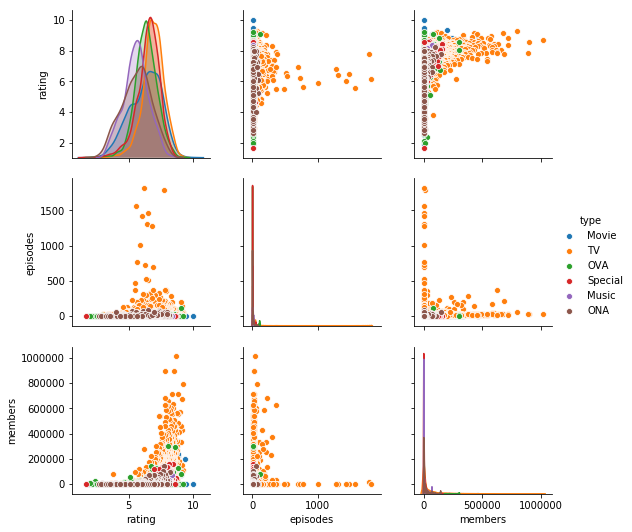

In [21]:
sns.pairplot(data=df_anime[['type','rating','episodes','members']].dropna(),hue='type')

- La distribución de los ratings es __Leptocúrtica__ ---->  es decir existe una gran concentración de los valores en torno a su media, con mayor presencia entre los ranking 5 y 8 (y algunos ouliers)
- En base a ello llenaremos los valores faltantes usando la MEDIANA de los rating 

(array([2.300e+02, 2.000e+00, 2.200e+01, 2.110e+02, 7.520e+02, 2.372e+03,
        4.784e+03, 3.294e+03, 6.030e+02, 2.400e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

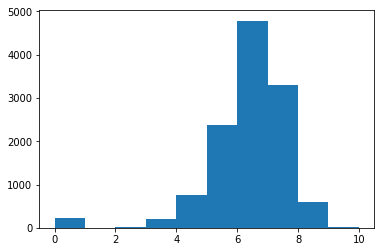

In [22]:
plt.hist(df_anime['rating'].fillna(0))

In [23]:
# rellenamos nan con la media 
df_anime['rating'] =df_anime['rating'].fillna(df_anime.rating.median())

(array([   6.,   49.,  275.,  733., 1824., 3884., 3822., 1467.,  225.,
           9.]),
 array([ 1.67 ,  2.503,  3.336,  4.169,  5.002,  5.835,  6.668,  7.501,
         8.334,  9.167, 10.   ]),
 <a list of 10 Patch objects>)

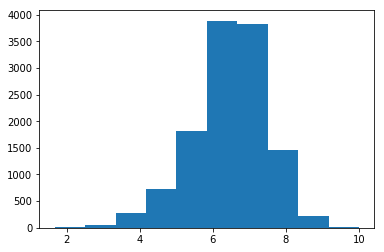

In [24]:
plt.hist(df_anime['rating'].fillna(0))

In [ ]:
# es posible ver el cambio en la distribucion

In [26]:
# Veamos especificamente cuantas valoraciones existen

pd.DataFrame(df_ratings.groupby('rating').user_id.count()).reset_index()

rating  user_id
0     1.0    16649
1     2.0    23150
2     3.0    41453
3     4.0   104291
4     5.0   282806
5     6.0   637775
6     7.0  1375287
7     8.0  1646019
8     9.0  1254096
9    10.0   955715

In [34]:
df_ratings.count() #hay datos perdidos en rating 

user_id     7813737
anime_id    7813737
rating      6337241
dtype: int64

In [35]:
# selección de animes que tengan cantidad de rating superior a 80 para hacer mas rapida la consulta
# para ello explorar distribucion x tipo

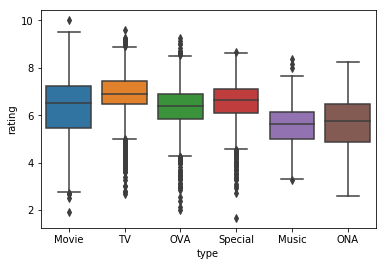

In [36]:
sns.boxplot(data = df_anime, y = 'rating', x='type')

__Priorizamos catogorizar por genero. Tambien cuantos usser han visto cada anime__

(array([1.0675e+04, 3.4500e+02, 1.0000e+02, 4.5000e+01, 1.7000e+01,
        7.0000e+00, 7.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 3.93490e+03, 7.86880e+03, 1.18027e+04, 1.57366e+04,
        1.96705e+04, 2.36044e+04, 2.75383e+04, 3.14722e+04, 3.54061e+04,
        3.93400e+04]),
 <a list of 10 Patch objects>)

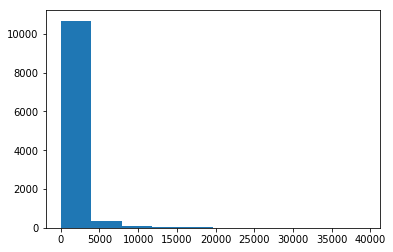

In [37]:
plt.hist(df_ratings.groupby(['anime_id'])['anime_id'].count())

Existe un sesgo, pues recomendara las series mas vistas sobre las menos vistas (Ver grafico)

La informacion del dataset establese que las serie  series sin rating no han sido evaluadas ya que no se encuentran aun en emision o no han sido lanzadas, por lo que trataremos que nuestro sistema tambien sea capaz de recomendarlas.

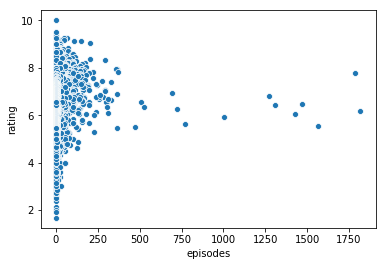

In [39]:
sns.scatterplot( x = df_anime['episodes'], y= df_anime['rating'])

Se prefiere anime con menor cantidad de episodios

## Representaciones Matriciales

* Unimos los datasets para extraer subsets de entrenamiento!

In [40]:
fulldf = pd.merge(df_anime, df_ratings, how = 'right', on ='anime_id', suffixes = ['_avg', '_user'])
fulldf.rename(columns = {'rating_user':'user_rating', 'rating_avg':'avg_rating'}, inplace = True)

In [41]:
fulldf.sample(10)

anime_id                                        name  \
6065634       149                                    Loveless   
682797      22789                                   Barakamon   
2326547     15809                         Hataraku Maou-sama!   
7030243     26351              Nagato Yuki-chan no Shoushitsu   
3347950       182                        Tenkuu no Escaflowne   
7234455     17157                                  Nozoki Ana   
6759519      2131              Bokusatsu Tenshi Dokuro-chan 2   
2543645       269                                      Bleach   
3579245     10278                              The iDOLM@STER   
2042521      3665  Ginga Eiyuu Densetsu Gaiden: Rasen Meikyuu   

                                                     genre type  episodes  \
6065634  Action, Drama, Fantasy, Mystery, Romance, Shou...   TV      12.0   
682797                               Comedy, Slice of Life   TV      12.0   
2326547          Comedy, Demons, Fantasy, Romance, Shounen   TV      13.0   
7030243     Comedy, Romance, School, Seinen, Slice of Life   TV      16.0   
3347950         Adventure, Fantasy, Mecha, Romance, Shoujo   TV      26.0   
7234455                               Comedy, Drama, Ecchi  OVA       1.0   
6759519                               Comedy, Ecchi, Magic  OVA       2.0   
2543645  Action, Comedy, Shounen, Super Power, Supernat...   TV     366.0   
3579245                               Comedy, Drama, Music   TV      25.0   
2042521                     Drama, Military, Sci-Fi, Space  OVA      28.0   

         avg_rating   members  user_id  user_rating  
6065634        7.19   85554.0    44068          9.0  
682797         8.50  225927.0    20593          9.0  
2326547        8.03  409037.0     2968          9.0  
7030243        6.77   62601.0    72797          NaN  
3347950        7.80   83437.0    63552          9.0  
7234455        6.63   21200.0    13877          7.0  
6759519        6.92   70734.0    50813          8.0  
2543645        7.95  624055.0    45487          8.0  
3579245        7.75   81155.0    63357          NaN  
2042521        8.10    7712.0    41137          NaN

In [ ]:
#Extraer un subset para el filtro colaborativo

In [42]:
df_col = fulldf[['user_id', 'name', 'user_rating']]
df_col.head()

user_id            name  user_rating
0       99  Kimi no Na wa.          5.0
1      152  Kimi no Na wa.         10.0
2      244  Kimi no Na wa.         10.0
3      271  Kimi no Na wa.         10.0
4      278  Kimi no Na wa.          NaN

In [44]:
df_genres_list = df_anime['genre'].str.get_dummies(sep = ', ')

## Para el filtro de Contenido

In [45]:
df_genres_list.sample(10)

Action  Adventure  Cars  Comedy  Dark Fantasy  Dementia  Demons  Drama  \
1599       0          0     0       1             0         0       0      0   
4425       0          0     0       1             0         0       0      0   
8769       0          0     0       0             0         0       0      1   
2544       0          0     0       1             0         0       0      0   
75         1          0     0       0             0         0       0      0   
3050       0          0     0       0             0         0       0      0   
3073       1          0     0       0             0         0       0      0   
8056       0          0     0       0             0         0       0      0   
5277       1          0     0       0             0         0       0      1   
710        0          0     0       1             0         0       0      0   

      Ecchi  Fantasy  ...  Shounen Ai  Slice of Life  Space  Sports  \
1599      0        0  ...           0              0      0       0   
4425      0        0  ...           0              0      0       0   
8769      0        0  ...           0              0      0       0   
2544      1        0  ...           0              1      0       0   
75        0        0  ...           0              0      0       0   
3050      0        0  ...           0              0      0       1   
3073      0        0  ...           0              0      0       0   
8056      0        0  ...           0              0      0       0   
5277      0        0  ...           0              0      0       0   
710       0        0  ...           0              0      0       0   

      Super Power  Supernatural  Thriller  Vampire  Yaoi  Yuri  
1599            0             0         0        0     0     0  
4425            0             0         0        0     0     0  
8769            0             0         0        0     0     0  
2544            0             0         0        0     0     0  
75              0             0         0        0     0     0  
3050            0             0         0        0     0     0  
3073            0             0         0        0     0     0  
8056            0             0         0        0     0     0  
5277            0             0         0        0     0     0  
710             0             0         0        0     0     0  

[10 rows x 46 columns]

In [46]:
df_types_list = pd.get_dummies(df_anime[["type"]])
df_types_list.sample(10)

type_Movie  type_Music  type_ONA  type_OVA  type_Special  type_TV
4162            0           0         0         0             0        1
914             1           0         0         0             0        0
2140            1           0         0         0             0        0
11272           0           0         0         1             0        0
3588            0           0         0         1             0        0
11345           0           0         0         1             0        0
8681            0           0         1         0             0        0
2989            0           0         1         0             0        0
121             0           0         0         0             0        1
5404            0           0         0         0             0        1

In [48]:
#crear el dataset de entrenamiento final para contenido
df_feat = df_anime[['members','rating','episodes']]
df_features = pd.concat([df_feat,df_genres_list, df_types_list], axis = 1).fillna(0)

In [ ]:
#funciones de Apoyo

In [49]:
def get_nombre_from_index(index):
    return df_anime[df_anime.index == index]['name'].values[0]
def get_id_from_nombre(name):
    return df_anime[df_anime.name == name]['anime_id'].values[0]
def get_index_from_id(anime_id):
    return df_anime[df_anime.anime_id == anime_id].index.values[0]

In [50]:
#Obtendremos el promedio de las valoraciones que el usuario ha dado a las series para determinar si le gustan
# recomendaremos series similares a sus favoritas o mejor valoradas.
## Consideraremos el valor promedio de las series que el usuario haya evaluado
def get_user_top_list(user):
    df_user = df_ratings[df_ratings['user_id']==user]
    df_rated = df_user.dropna(how = 'any')
    avg =  df_rated.rating.mean() 
    df_toplist = df_rated[df_rated['rating']>= avg].sort_values('rating', ascending = False).head(10)
    return list(df_toplist['anime_id'])
def get_user_viewed_list(user):
    return list(df_ratings[df_ratings['user_id']==user]['anime_id'])

## Modelado por KNN (Contenido)

* Se usa k = K+1 siendo K el numero de recomendaciones que se desea obtener, ya que la primera siempre es el mismo dato
* Como tenemos variables dummy binarias vs variables con valor muy alto (episodios, miembros) se utilizara  la biblioteca MaxAbsScaler para convertir dichos valores en una distribucion 0-1. Equivale a normalizar con funcion Z

In [51]:
mas = MaxAbsScaler()
df_features2 = mas.fit_transform(df_features)

In [54]:
k = 10

In [55]:
neighbors_content = NearestNeighbors(n_neighbors = k, algorithm = 'ball_tree')

In [56]:
neighbors_content.fit(df_features2)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [57]:
distances, indices = neighbors_content.kneighbors(df_features2)

In [58]:
distances.shape

(12294, 10)

In [59]:
indices.shape

(12294, 10)

In [ ]:
#Extraer una serie al azar para evaluar el modelo y ver como se comporta

In [60]:
series = np,random.randint(0,len(indices))
print(series[1])
name = get_nombre_from_index(series[1])
print(name)

748
Hellsing I: Digest for Freaks


In [61]:
aid = get_id_from_nombre(name)

In [62]:
ind = get_index_from_id(aid)

In [63]:
anime = ind
list(indices[anime,1:11])

[66, 1099, 2043, 5076, 6946, 7408, 1183, 7884, 7990]

In [64]:
def get_recommendations(aid):
    anime =  get_index_from_id(aid)
    test = list(indices[anime,1:11])
    nb = []
    for i in test:
        a_name = get_nombre_from_index(i)
        nb.append(a_name)
    return nb

### Ver comparacion entre la recomendacion y la serie

* Extraer las series que el usuario ya haya visto

In [65]:
get_user_top_list(73509)

[199]

In [66]:
get_recommendations(23283)

['Re:Zero kara Hajimeru Isekai Seikatsu',
 'Mahou Shoujo Madoka★Magica',
 'Higurashi no Naku Koro ni Kai',
 'Gyakkyou Burai Kaiji: Ultimate Survivor',
 'Selector Infected WIXOSS',
 'Gyakkyou Burai Kaiji: Hakairoku-hen',
 'Touhai Densetsu Akagi: Yami ni Maiorita Tensai',
 'Selector Spread WIXOSS',
 'Steins;Gate']

* Recomendar series hasta que encontremos n series que el usuario no ha visto

In [67]:
def get_n_recommends(user, n):
    vistas = list(get_user_viewed_list(user))
    liked = list(get_user_top_list(user))
    lista = []
    for i in liked:
        ani = pd.Series(get_recommendations(i))
        recs = np.setdiff1d(ani, vistas) 
        lista.extend(recs)
        if(len(lista) > n):
            lista = lista[n:]
            break
    return lista

* probar para un usuario cualquiera de acuerdo a la lista anterior

In [68]:
get_n_recommends(3,5)

['Saint Luminous Jogakuin',
 'Shinreigari: Ghost Hound',
 'UN-GO',
 'Umineko no Naku Koro ni']

In [69]:
get_n_recommends(73509, 10)

['Bakemono no Ko',
 'Da Yu Hai Tang',
 'Jungle Taitei Leo: Hon-o-ji',
 'Mai Mai Shinko to Sennen no Mahou',
 'Marco: Haha wo Tazunete Sanzenri',
 'Momo e no Tegami',
 'Oseam',
 'Shisha no Sho',
 'Tobe! Kujira no Peek']

In [70]:
get_n_recommends(2, 10)

['Area no Kishi',
 'Diamond no Ace',
 'Diamond no Ace: Second Season',
 'Haikyuu!!',
 'Kuroko no Basket 2nd Season',
 'Kuroko no Basket 3rd Season',
 'Teekyuu',
 'Teekyuu 2',
 'Teekyuu 3']

Nota: Knn en ejecución, es probable que ocurran cambios